In [220]:
# data munging and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import itertools

# timestamps
import datetime


# feature engineering
import featuretools as ft

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import os

## Users

In [221]:
users = pd.read_csv('data/users_Feb_1_30days_cohort.csv')
users['bux_account_created_dts'] = pd.to_datetime(users['bux_account_created_dts'])
users = users[users.columns[1:]]
len(users)

58839

In [222]:
sample_num = 30000
sample_users = users[0:sample_num]

In [223]:
users.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits
0,031b0f17-9a45-4b1b-b7b4-027802ffad95,DE,MALE,DE,iOS,SOME,Experienced Trader,Appnext,2017-02-03 21:10:20.056,SERIOUS_BUX,2017-02-13 22:11:52.000,450.0,450.0,1.0
1,010e236f-8ab5-4681-a146-273531d19d54,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 16:33:27.777,FUN_BUX,NaN,NaN,NaN,NaN
2,011f6526-ab7e-4790-b289-5fa1faf69bc3,AT,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-26 11:55:06.928,FUN_BUX,NaN,NaN,NaN,NaN
3,0231bd62-6733-4f8b-9c57-87f4eb9e0aa1,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-17 23:14:11.280,FUN_BUX,NaN,NaN,NaN,NaN
4,028e03b9-ab6d-4ede-85f2-ce6b6e38ad47,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-20 10:30:34.584,FUN_BUX,NaN,NaN,NaN,NaN


In [224]:
users['bux_account_created_day'] = [ts.day for ts in users['bux_account_created_dts']]
users['bux_account_created_day'].head()

0     3
1     1
2    26
3    17
4    20
Name: bux_account_created_day, dtype: int64

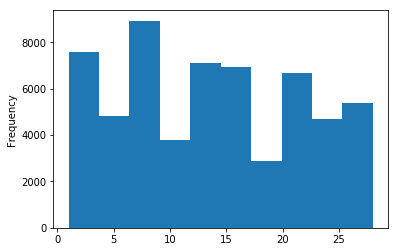

In [225]:
users['bux_account_created_day'].plot(kind='hist');

In [226]:
# 30 users in the sample that created an accountusers[users['bux_account_created_day'] == 10]['user_id'].count()

In [227]:
len(users)

58839

## Cube daily user

In [228]:
transactions = pd.read_csv('data/cube_daily_user_Feb_1_30days_cohort.csv')
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions[transactions.columns[1:]]
transactions = transactions.reset_index()
transactions.head()

,index,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,0,000c5e5d-4e25-412d-951b-31167045eb95,60,2017-03-01,0,0,FUN_BUX,0,0.0,0,Following,0
1,1,000c5e5d-4e25-412d-951b-31167045eb95,61,2017-03-02,0,0,FUN_BUX,0,0.0,0,Following,0
2,2,000c5e5d-4e25-412d-951b-31167045eb95,62,2017-03-03,0,0,FUN_BUX,0,0.0,0,Following,0
3,3,000c5e5d-4e25-412d-951b-31167045eb95,65,2017-03-06,0,0,FUN_BUX,0,0.0,0,Following,0
4,4,000c5e5d-4e25-412d-951b-31167045eb95,66,2017-03-07,0,0,FUN_BUX,0,0.0,0,Following,0


In [229]:
len(transactions)

370117

In [230]:
len(transactions['user_id'].unique())

58045

In [231]:
len(transactions.columns)

12

In [232]:
sample_transactions = transactions[transactions['user_id'].isin(sample_users['user_id'])]
len(sample_transactions)

192577

## Target values (Current customer value - CurCV)

In [233]:
CurCV = pd.read_csv('data/curCv_Feb_1_30days_cohort.csv')
CurCV = CurCV[CurCV.columns[1:]]
CurCV = CurCV.fillna(0)
CurCV.head()

,user_id,com,div,ff,total
0,62975554-fc1c-46c9-8a7c-80b8ed710284,0.0,0.0,0.0,0.0
1,84a09b40-e773-4ca5-8e0b-4dcfe5a34b00,0.0,0.0,0.0,0.0
2,0c743fbc-d056-4957-9c90-d92f893defc0,0.0,0.0,0.0,0.0
3,cfab8dd2-d4c8-490c-9452-581acd5ebdf7,0.0,0.0,0.0,0.0
4,a9727139-75e6-41b0-8428-6b2a7d2ff893,0.0,0.0,0.0,0.0


In [234]:
CurCV = CurCV[['user_id', 'total']]
CurCV.columns = ['user_id', 'curcv']
CurCV.head()

,user_id,curcv
0,62975554-fc1c-46c9-8a7c-80b8ed710284,0.0
1,84a09b40-e773-4ca5-8e0b-4dcfe5a34b00,0.0
2,0c743fbc-d056-4957-9c90-d92f893defc0,0.0
3,cfab8dd2-d4c8-490c-9452-581acd5ebdf7,0.0
4,a9727139-75e6-41b0-8428-6b2a7d2ff893,0.0


In [235]:
sample_CurCV = CurCV[CurCV['user_id'].isin(sample_users['user_id'])]
len(sample_CurCV)

30000

## Define entities, entity tables and relationships

In [236]:
users = sample_users
users[0:5]

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits
0,031b0f17-9a45-4b1b-b7b4-027802ffad95,DE,MALE,DE,iOS,SOME,Experienced Trader,Appnext,2017-02-03 21:10:20.056,SERIOUS_BUX,2017-02-13 22:11:52.000,450.0,450.0,1.0
1,010e236f-8ab5-4681-a146-273531d19d54,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 16:33:27.777,FUN_BUX,NaN,NaN,NaN,NaN
2,011f6526-ab7e-4790-b289-5fa1faf69bc3,AT,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-26 11:55:06.928,FUN_BUX,NaN,NaN,NaN,NaN
3,0231bd62-6733-4f8b-9c57-87f4eb9e0aa1,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-17 23:14:11.280,FUN_BUX,NaN,NaN,NaN,NaN
4,028e03b9-ab6d-4ede-85f2-ce6b6e38ad47,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-20 10:30:34.584,FUN_BUX,NaN,NaN,NaN,NaN


In [237]:
transactions = sample_transactions
transactions[0:5]

,index,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
8,8,00193156-af2f-430a-9c2d-4bd8589172f0,60,2017-03-01,5,87,FUN_BUX,1,0.0,2,Chatting,0
9,9,00193156-af2f-430a-9c2d-4bd8589172f0,61,2017-03-02,1,23,FUN_BUX,0,0.0,2,Chatting,0
10,10,00193156-af2f-430a-9c2d-4bd8589172f0,64,2017-03-05,1,27,FUN_BUX,0,0.0,2,Chatting,0
11,11,00193156-af2f-430a-9c2d-4bd8589172f0,65,2017-03-06,2,10,FUN_BUX,0,0.0,2,Chatting,0
12,12,001969e1-e1ea-455d-87de-29e6424ba5ba,65,2017-03-06,2,450,FUN_BUX,0,0.0,1,Following,0


In [238]:
CurCV = sample_CurCV
CurCV.head()

,user_id,curcv
2,0c743fbc-d056-4957-9c90-d92f893defc0,0.0
3,cfab8dd2-d4c8-490c-9452-581acd5ebdf7,0.0
6,3bb4e055-9d9d-4188-a4d2-398066566bfc,0.0
8,b78a93e2-5b0f-4d93-bc87-2f0c2b511522,0.0
9,2056ee02-c98b-4503-989b-e17c1e447eff,0.0


In [239]:
es = ft.EntitySet("bux_cltv")

In [240]:
es.entity_from_dataframe(entity_id='users',
                        dataframe=users,
                        index='user_id',
                        time_index='bux_account_created_dts')

Entityset: bux_cltv
  Entities:
    users (shape = [30000, 14])
  Relationships:
    No relationships

In [241]:
es.entity_from_dataframe(entity_id='transactions',
                        dataframe=transactions,
                        index='index',
                        time_index='date')

Entityset: bux_cltv
  Entities:
    users (shape = [30000, 14])
    transactions (shape = [192577, 12])
  Relationships:
    No relationships

In [242]:
es.add_relationship(ft.Relationship(es['users']['user_id'], es['transactions']['user_id']))

Entityset: bux_cltv
  Entities:
    users (shape = [30000, 14])
    transactions (shape = [192577, 12])
  Relationships:
    transactions.user_id -> users.user_id

## Building labels

In [243]:
# 70 euros 1 year customer value-> a user whale or not whale
ninetynine_perc = CurCV['curcv'].quantile(0.97)
ninetynine_perc

2.500299999999988

In [244]:
CurCV['whale'] = (CurCV['curcv'] > ninetynine_perc).astype(int)

In [245]:
CurCV['whale'].value_counts()

0    29100
1      900
Name: whale, dtype: int64

In [246]:
# number of whales
whales = CurCV[CurCV['curcv'] >= ninetynine_perc]
len(whales)

900

In [247]:
non_whales = CurCV[CurCV['curcv'] < ninetynine_perc]
len(non_whales)

29100

In [248]:
# 1y CV
CurCV['curcv'].mean(), CurCV['curcv'].median()

(7.518087666666662, 0.0)

In [249]:
# cohort value
CurCV['curcv'].sum()

225542.63

In [250]:
# max value
CurCV['curcv'].max()

39811.330000000002

In [251]:
# CurCV['whale'].plot(kind='bar')

- Training window = the amount of historical data we want to use when calculating features
- cutoff_time = the point in time to calculate the features

We use cutoff times to avoid the risk of leaking labels into prediction

In [252]:
min(transactions['date'].unique()), max(transactions['date'].unique())

(numpy.datetime64('2017-02-01T00:00:00.000000000'),
 numpy.datetime64('2017-03-22T00:00:00.000000000'))

In [253]:
"""

cutoff_time = pd.Timestamp('Feb 10, 2017')
# 1 month prediction window
prediction_window = ft.Timedelta("3 weeks")
# 6 months of training data
training_window = ft.Timedelta("10 days")

prediction_window_end = cutoff_time + prediction_window
t_start = cutoff_time - training_window


cutoff_time = pd.Timestamp('Mar 1, 2017')
# 1 month prediction window
prediction_window = ft.Timedelta("1 day")
# 6 months of training data
training_window = ft.Timedelta("4 weeks")

prediction_window_end = cutoff_time + prediction_window
t_start = cutoff_time - training_window
prediction_window_end

t_start
transactions.head()

"""

'\n\ncutoff_time = pd.Timestamp(\'Feb 10, 2017\')\n# 1 month prediction window\nprediction_window = ft.Timedelta("3 weeks")\n# 6 months of training data\ntraining_window = ft.Timedelta("10 days")\n\nprediction_window_end = cutoff_time + prediction_window\nt_start = cutoff_time - training_window\n\n\ncutoff_time = pd.Timestamp(\'Mar 1, 2017\')\n# 1 month prediction window\nprediction_window = ft.Timedelta("1 day")\n# 6 months of training data\ntraining_window = ft.Timedelta("4 weeks")\n\nprediction_window_end = cutoff_time + prediction_window\nt_start = cutoff_time - training_window\nprediction_window_end\n\nt_start\ntransactions.head()\n\n'

In [254]:
# transactions sorted by the date
trans = es['transactions'].df
trans['date'][0:5]

index
3225   2017-02-01
4387   2017-02-01
4469   2017-02-01
4553   2017-02-01
5437   2017-02-01
Name: date, dtype: datetime64[ns]

In [255]:
# # get the first launch of a user
# # user_created = pd.DataFrame(trans.groupby('user_id')['date'].min()).reset_index()

# user_last_event_last = pd.DataFrame(trans.groupby('user_id')['date'].max()).reset_index()
# user_last_event_last = user_last_event_last['date'].max()
# user_last_event_last

In [256]:
# cutoff_time = '2017-02-20'
# users_in_training = user_created[user_created['date'] < cutoff_time]['user_id']
# len(users_in_training)

In [257]:
# training_data = trans[trans['user_id'].isin(users_in_training)]
# validation_data = trans[~trans['user_id'].isin(users_in_training)]

In [258]:
# len(training_data)

In [259]:
# len(validation_data)

In [260]:
# # the raw feature values
# training_data = trans[(trans['date'] <= cutoff_time) & (trans['date'] > t_start)]
# # to compute the label
# prediction_data = trans[(trans['date'] > cutoff_time) & (trans['date'] < prediction_window_end)]

In [261]:
# users_in_training = training_data['user_id'].unique()

In [262]:
# prediction_data['user_id'].isin(users_in_training)[0:5]

In [263]:
# ~something.isin(somewhere)
# ~prediction_data['user_id'].isin(users_in_training)[0:5]

In [264]:
# valid_pred_data = prediction_data[~prediction_data['user_id'].isin(users_in_training)]

In [265]:
# len(training_data['user_id'].unique())

In [266]:
# len(valid_pred_data['user_id'].unique())

In [267]:
# label_times = CurCV[CurCV['user_id'].isin(users_in_training)][['user_id', 'whale']]
# label_times = label_times.merge(user_created, on ='user_id')
# label_times['cutoff_time'] = user_last_event_last
# # label_times['cutoff_time'] =  label_times['date'] + datetime.timedelta(weeks=3)
# # label_times['cutoff_time'] = cutoff_time
# label_times.head()

In [268]:
# print(" First launch:", transactions[transactions['user_id'] == 'a9727139-75e6-41b0-8428-6b2a7d2ff893']['date'].min(), "\n" ,
#      "Three weeks after first launch:" + " 3 weeks of usage: ", transactions[transactions['user_id'] == 'a9727139-75e6-41b0-8428-6b2a7d2ff893']['date'].min() + datetime.timedelta(weeks=3))

## Automated feature engineering

In [269]:
es['users'].head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits
user_id,,,,,,,,,,,,,,
65c8c310-d0f9-4e38-bc56-5228c8290755,65c8c310-d0f9-4e38-bc56-5228c8290755,DE,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-01 00:02:28.610,FUN_BUX,NaT,NaN,NaN,NaN
72fda13b-6385-42e3-8607-e9df7d877b66,72fda13b-6385-42e3-8607-e9df7d877b66,DE,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 00:03:06.424,FUN_BUX,NaT,NaN,NaN,NaN
f47e9b1b-0778-4809-98ff-008ad8df347a,f47e9b1b-0778-4809-98ff-008ad8df347a,DE,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2017-02-01 00:04:30.705,FUN_BUX,NaT,NaN,NaN,NaN
1c4c7025-5ca7-445d-ad9d-22fd397944e3,1c4c7025-5ca7-445d-ad9d-22fd397944e3,DE,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-02-01 00:05:25.479,FUN_BUX,NaT,NaN,NaN,NaN
390f4493-89f7-46aa-b717-49ac81f630f7,390f4493-89f7-46aa-b717-49ac81f630f7,DE,NaN,NaN,iOS,NONE,Rookie Trader,Viral Invites,2017-02-01 00:05:26.389,FUN_BUX,NaT,NaN,NaN,NaN
80505c8e-2f64-4f79-bf3e-72e5acf86986,80505c8e-2f64-4f79-bf3e-72e5acf86986,DE,NaN,NaN,iOS,NONE,Rookie Trader,Organic,2017-02-01 00:05:36.067,FUN_BUX,NaT,NaN,NaN,NaN
1322c37f-b82e-475c-971c-12166b50ff5d,1322c37f-b82e-475c-971c-12166b50ff5d,DE,NaN,NaN,iOS,NONE,Rookie Trader,Facebook Installs,2017-02-01 00:05:45.406,FUN_BUX,NaT,NaN,NaN,NaN
1f84ae24-a906-4eef-a6b4-141c268ec727,1f84ae24-a906-4eef-a6b4-141c268ec727,DE,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-02-01 00:06:14.630,FUN_BUX,NaT,NaN,NaN,NaN
9a06ddd4-14be-475e-a0e5-a5dd185ecf66,9a06ddd4-14be-475e-a0e5-a5dd185ecf66,DK,MALE,DK,iOS,NONE,Rookie Trader,Facebook Installs,2017-02-01 00:06:32.373,FUN_BUX,NaT,NaN,NaN,NaN


In [270]:
es['transactions'].head()

,index,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
index,,,,,,,,,,,,
3225,3225,01060844-879c-41a4-bb11-368521a50a3d,32,2017-02-01,2,666,FUN_BUX,0,0.00,0,Following,0
4387,4387,0176657e-73d7-490d-9c0e-09983ecce3bd,32,2017-02-01,13,2142,FUN_BUX,0,0.00,0,Following,0
4469,4469,01d9b716-4f45-4696-9b6d-0bc2b501ddf9,32,2017-02-01,2,115,FUN_BUX,0,0.00,0,Non-Social,0
4553,4553,0211f774-2934-4777-8e58-ab159acb74d9,32,2017-02-01,1,337,FUN_BUX,0,0.00,0,Non-Social,0
5437,5437,0056c5ce-7e6b-437f-ab2f-1f5d24874734,32,2017-02-01,26,2626,FUN_BUX,1,13.20,0,Non-Social,0
5582,5582,00eceec7-aaff-4c8c-af0e-1fee08f24b7c,32,2017-02-01,2,348,FUN_BUX,0,0.00,0,Non-Social,0
5609,5609,010e236f-8ab5-4681-a146-273531d19d54,32,2017-02-01,14,740,FUN_BUX,1,0.54,0,Non-Social,0
5641,5641,0129a588-e011-4fe5-907e-6d5f6629b7e1,32,2017-02-01,4,1393,FUN_BUX,0,0.00,1,Following,0
6686,6686,01fc6d47-cc88-433d-ad49-fce76379ea6b,32,2017-02-01,1,50,FUN_BUX,0,0.00,0,Non-Social,0


In [271]:
from dask import bag
from dask.diagnostics import ProgressBar

In [272]:
# %%time

# from featuretools.primitives import (Sum, Std, Max, Min, Mean,
#                                      Count, PercentTrue, NUnique, 
#                                      Mode, Trend, Skew)


# agg_primitives = [Sum, Std, Max, Min, Mean, 
#                   Count, PercentTrue, NUnique, 
#                   Mode, Trend, Skew]

# feature_matrix, features = ft.dfs(
#     entityset=es,
#     target_entity="users",
#     trans_primitives=[],
#     agg_primitives=agg_primitives,
#     max_depth=3,
#     # cutoff_time=cutoff_times,
#     verbose=True
# )

# print("{} features generated".format(len(features)))

In [273]:
# %%time

# from featuretools.primitives import (Sum, Std, Max, Min, Mean,
#                                      Count, PercentTrue, NUnique, 
#                                      Mode, Trend, Skew)


# agg_primitives = [Sum, Std, Max, Min, Mean, 
#                   Count, PercentTrue, NUnique, 
#                   Mode]

# feature_matrix, features = ft.dfs(
#     entityset=es,
#     target_entity="users",
#     trans_primitives=[],
#     agg_primitives=agg_primitives,
#     max_depth=3,
#     # cutoff_time=cutoff_times,
#     verbose=True
# )

# print("{} features generated".format(len(features)))

In [274]:
%%time

from featuretools.primitives import (Sum, Std, Max, Min, Mean,
                                     Count, PercentTrue, NUnique, 
                                     Mode, Trend, Skew)


agg_primitives = [Sum, Std, Max, Min, Mean, 
                  Count, PercentTrue, NUnique, 
                  Mode]

feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="users",
    trans_primitives=[],
    agg_primitives=agg_primitives,
    max_depth=2,
    # cutoff_time=cutoff_times,
    verbose=True
)

print("{} features generated".format(len(features)))

Building features: 66it [00:00, 2597.53it/s]
Progress: 100%|██████████| 1/1 [07:15<00:00, 435.86s/cutoff time]
51 features generated
CPU times: user 7min 13s, sys: 1.59 s, total: 7min 15s
Wall time: 7min 16s


In [275]:
# encode categorical features
fm_encoded, features_encoded = ft.encode_features(feature_matrix, features)


print('Number of features %s' % len(features_encoded))
fm_encoded.head()

Number of features 95


,network = Facebook Installs,network = Organic,network = Viral Invites,network = TV,network = Google Adwords Search,network = Instagram Installs,network = Appnext,network = BUX Website,network = AdColony,network = Finanzen.net,...,MIN(transactions.number_of_sessions),STD(transactions.conversion_to_sb),COUNT(transactions),NUM_UNIQUE(transactions.account_status),MAX(transactions.conversion_to_sb),STD(transactions.day_of_year),MIN(transactions.total_session_duration),MEAN(transactions.number_of_sessions),SUM(transactions.trades_fb_commodities_open),MIN(transactions.trades_fb_commodities_open)
user_id,,,,,,,,,,,,,,,,,,,,,
0000c78d-d1ba-4758-8b0d-8503058aaa4e,1,0,0,0,0,0,0,0,0,0,...,1.0,0.0,2.0,1.0,0.0,7.500000,21.0,3.0,0.0,0.0
00028e09-fcff-4368-9409-e9419efec176,0,1,0,0,0,0,0,0,0,0,...,2.0,0.0,1.0,1.0,0.0,0.000000,256.0,2.0,0.0,0.0
0005d4cf-4eeb-4255-88ee-fdf2c662396c,0,0,0,1,0,0,0,0,0,0,...,2.0,0.0,1.0,1.0,0.0,0.000000,14.0,2.0,0.0,0.0
00063093-cd4a-4b44-93f0-ef23912da5db,1,0,0,0,0,0,0,0,0,0,...,1.0,0.0,2.0,1.0,0.0,1.000000,12.0,1.0,0.0,0.0
0006cadf-59f8-46d5-b085-1d0c7701e2a1,0,0,1,0,0,0,0,0,0,0,...,2.0,0.0,3.0,1.0,0.0,0.816497,28.0,4.0,0.0,0.0


## Machine learning

In [276]:
# if building features on all users
len(users) == len(fm_encoded)

# if buiding features only on training users
# len(fm_encoded) == len(users_in_training)

True

In [277]:
CurCV.head()

,user_id,curcv,whale
2,0c743fbc-d056-4957-9c90-d92f893defc0,0.0,0
3,cfab8dd2-d4c8-490c-9452-581acd5ebdf7,0.0,0
6,3bb4e055-9d9d-4188-a4d2-398066566bfc,0.0,0
8,b78a93e2-5b0f-4d93-bc87-2f0c2b511522,0.0,0
9,2056ee02-c98b-4503-989b-e17c1e447eff,0.0,0


In [278]:
# add the target labels to the feature set (fm_encoded)
# X = fm_encoded.reset_index().merge(label_times)
X = fm_encoded.reset_index().merge(CurCV)


# drop the user_id and cutoff_time (no information gain)
X.drop(['user_id', 'curcv'], axis=1, inplace=True)

# fill all NaN values as 0s
X = X.fillna(0)
# pop = return an item and drop from the frame
y = X.pop('whale').astype('int')

In [279]:
# class (im)balance
y.value_counts()

0    29100
1      900
Name: whale, dtype: int64

In [280]:
X.head()

,network = Facebook Installs,network = Organic,network = Viral Invites,network = TV,network = Google Adwords Search,network = Instagram Installs,network = Appnext,network = BUX Website,network = AdColony,network = Finanzen.net,...,MIN(transactions.number_of_sessions),STD(transactions.conversion_to_sb),COUNT(transactions),NUM_UNIQUE(transactions.account_status),MAX(transactions.conversion_to_sb),STD(transactions.day_of_year),MIN(transactions.total_session_duration),MEAN(transactions.number_of_sessions),SUM(transactions.trades_fb_commodities_open),MIN(transactions.trades_fb_commodities_open)
0,1,0,0,0,0,0,0,0,0,0,...,1.0,0.0,2.0,1.0,0.0,7.500000,21.0,3.0,0.0,0.0
1,0,1,0,0,0,0,0,0,0,0,...,2.0,0.0,1.0,1.0,0.0,0.000000,256.0,2.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,2.0,0.0,1.0,1.0,0.0,0.000000,14.0,2.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,1.0,0.0,2.0,1.0,0.0,1.000000,12.0,1.0,0.0,0.0
4,0,0,1,0,0,0,0,0,0,0,...,2.0,0.0,3.0,1.0,0.0,0.816497,28.0,4.0,0.0,0.0


In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [282]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [283]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [284]:
y_pred = clf.predict(X_test)

In [285]:
clf.score(X_test, y_test)

0.99688888888888894

In [286]:
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.99713617530681442, 0.99688888888888894, 0.99695352496179979, None)

In [287]:
# random forest classifer, 5-fold cross-validation
clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='roc_auc', verbose=True)
"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.9s finished


'AUC 1.00 +/- 0.00'

In [288]:
# get AUC score per each of the folds
scores

array([ 0.99907474,  0.99925704,  0.99903866])

In [289]:
cm = confusion_matrix(y_test, y_pred)

In [290]:
def plot_confusion_matrix(cm,
                          classes=[0, 1],
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Source:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

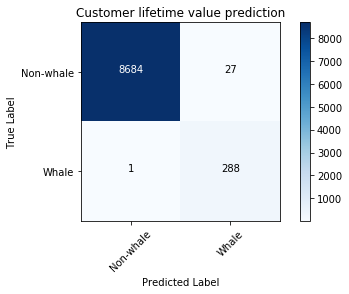

In [291]:
plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [299]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None)

array([ 0.99839043,  0.95364238])

In [303]:
# # feature importance calculation
# # get top n features

# importances = clf.feature_importances_
# n = 20

# zipped = sorted(zip(features, importances), key=lambda x: - x[1])

# for i, f in enumerate(zipped[:n]):
#     print("%d: Feature: %s, %.3f" % (i+1, f[0].get_name(), f[1]))
    
    
# top_features = [f[0] for f in zipped[:n]]
# top_features

In [304]:
def feature_importances(model, features, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(features, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0].get_name(), f[1]))

    return([f[0] for f in zipped[:n]])

In [305]:
top_features = feature_importances(clf, features_encoded, n=20)

1: Feature: sum_deposits, 0.144
2: Feature: cnt_deposits, 0.135
3: Feature: initial_deposit_amount, 0.131
4: Feature: account_type = SERIOUS_BUX, 0.097
5: Feature: account_type = FUN_BUX, 0.074
6: Feature: STD(transactions.conversion_to_sb), 0.064
7: Feature: SUM(transactions.conversion_to_sb), 0.048
8: Feature: MAX(transactions.conversion_to_sb), 0.038
9: Feature: MEAN(transactions.conversion_to_sb), 0.037
10: Feature: MODE(transactions.account_status) = SERIOUS_BUX, 0.028
11: Feature: NUM_UNIQUE(transactions.account_status), 0.026
12: Feature: MODE(transactions.account_status) = FUN_BUX, 0.016
13: Feature: SUM(transactions.total_session_duration), 0.011
14: Feature: SUM(transactions.number_of_sessions), 0.010
15: Feature: gender = unknown, 0.009
16: Feature: MAX(transactions.number_of_sessions), 0.008
17: Feature: gender = MALE, 0.008
18: Feature: STD(transactions.number_of_sessions), 0.007
19: Feature: STD(transactions.total_session_duration), 0.007
20: Feature: SUM(transactions.day

In [306]:
ft.save_features(top_features, "top_features")

### Retrain the classifier on top 20 features

In [307]:
# load in the features from before
top_features = ft.load_features("top_features", es)

In [311]:
%%time
fm = ft.calculate_feature_matrix(top_features,
                                 entityset=es,
                                 # cutoff_time = label_times,
                                 cutoff_time_in_index=True,
                                 verbose=False)

CPU times: user 5min 32s, sys: 597 ms, total: 5min 32s
Wall time: 5min 33s


## Classification

In [328]:
X = fm.reset_index().merge(CurCV[['user_id', 'whale']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("whale")

In [329]:
# top 20 features
len(X.columns)

20

In [330]:
y.value_counts()

0    29100
1      900
Name: whale, dtype: int64

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [336]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [337]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [338]:
y_pred = clf.predict(X_test)

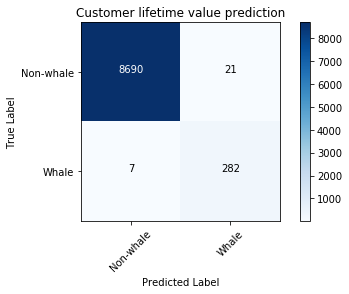

In [339]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

## Regression

In [343]:
X = fm.reset_index().merge(CurCV[['user_id', 'curcv']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("curcv")

In [345]:
# average customer value
y.mean()

7.518087666666671

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [348]:
from sklearn.ensemble import RandomForestRegressor

In [349]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [350]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [353]:
feature_importances(regr, features_encoded, n=20)

1: Feature: network = Facebook Installs, 0.951
2: Feature: gender = MALE, 0.030
3: Feature: network = Organic, 0.011
4: Feature: platform_type_name = Android, 0.008
5: Feature: network = Viral Invites, 0.000
6: Feature: network = TV, 0.000
7: Feature: network = Google Adwords Search, 0.000
8: Feature: network = Instagram Installs, 0.000
9: Feature: network = Appnext, 0.000
10: Feature: network = BUX Website, 0.000
11: Feature: network = AdColony, 0.000
12: Feature: network = Finanzen.net, 0.000
13: Feature: network = unknown, 0.000
14: Feature: cnt_deposits, 0.000
15: Feature: gender = FEMALE, 0.000
16: Feature: gender = unknown, 0.000
17: Feature: platform_type_name = iOS, 0.000
18: Feature: platform_type_name = unknown, 0.000
19: Feature: trading_experience = NONE, 0.000
20: Feature: trading_experience = SOME, 0.000


[<Feature: network = Facebook Installs>,
 <Feature: gender = MALE>,
 <Feature: network = Organic>,
 <Feature: platform_type_name = Android>,
 <Feature: network = Viral Invites>,
 <Feature: network = TV>,
 <Feature: network = Google Adwords Search>,
 <Feature: network = Instagram Installs>,
 <Feature: network = Appnext>,
 <Feature: network = BUX Website>,
 <Feature: network = AdColony>,
 <Feature: network = Finanzen.net>,
 <Feature: network = unknown>,
 <Feature: cnt_deposits>,
 <Feature: gender = FEMALE>,
 <Feature: gender = unknown>,
 <Feature: platform_type_name = iOS>,
 <Feature: platform_type_name = unknown>,
 <Feature: trading_experience = NONE>,
 <Feature: trading_experience = SOME>]

In [388]:
y_pred = regr.predict(X_test)

In [389]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [390]:
y_test.head()

2308     0.0
22404    0.0
23397    0.0
25058    0.0
2664     0.0
Name: curcv, dtype: float64

In [391]:
r2_reg = r2_score(y_test, y_pred).round(3)
r2_reg

0.60699999999999998

In [406]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

8.06045289324
12897.4587184
113.566978997


In [407]:
test_set_pred = sum(y_pred)
test_set_true = sum(y_test)

test_set_pred, test_set_true

(47132.284868087612, 69091.75)

In [408]:
test_set_benchmark = len(y_test) * CurCV['curcv'].mean()

test_set_benchmark, test_set_true

(67662.78899999996, 69091.75)

In [409]:
y_benchmark = [CurCV['curcv'].mean() for i in range(0,len(y_test))]

In [410]:
print(mean_absolute_error(y_test, y_benchmark))
print(mean_squared_error(y_test, y_benchmark))
print(np.sqrt(mean_squared_error(y_test, y_benchmark)))

14.7379637747
32789.0784159
181.077548072
